In [55]:
import matplotlib.pyplot as plt
import itertools
import numpy as np
import pandas as pd
from keras.utils.np_utils import to_categorical
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras.models import Sequential, load_model
from keras.datasets import mnist
import itertools
import random

In [56]:
# Load data and split into training and test
(train_images, train_labels), (test_images, test_labels) = mnist.load_data()

In [57]:
# Split training set further into training and validation sets
sample_size = 40000
X_train, X_val, y_train, y_val = train_images[:sample_size], train_images[sample_size:sample_size*2],  train_labels[:sample_size], train_labels[sample_size:sample_size*2]

Randomly sampling a subset of the data, to make the combinations more tractable. 

In [58]:
# Randomly select a defined number of image paires from a given dataset
def get_image_combinations(number_image_pairs_selected, image_data, image_labels):
    
    num_images_total = len(image_labels)
    
    image_combination_data = []
    image_combination_labels = []
    
    for i in range(number_image_pairs_selected):
        
        # Draw two image indices from a uniform random distribution
        random_index_A = random.randint(0, num_images_total-1)
        random_index_B = random.randint(0, num_images_total-1)
        
        # Randomly choose two images from the dataset
        image_A = image_data[random_index_A]
        image_B = image_data[random_index_B]
        
        # Merge images
        combined_images = np.hstack((image_A, image_B))
        
        # Find the minimum between the two labels
        label_A = image_labels[random_index_A]
        label_B = image_labels[random_index_B]
        minimum_label = min(label_A, label_B)
        
        # Append newly generated image combination and minimum label to list
        image_combination_data.append(combined_images)
        image_combination_labels.append(minimum_label)
        
    # Convert image data and labels lists to numpy arrays
    image_combination_data = np.array(image_combination_data)
    image_combination_labels = np.array(image_combination_labels)
    
    return image_combination_data, image_combination_labels

In [59]:
combo_train_X, combo_train_y = get_image_combinations(40000, X_train, y_train)
combo_val_X, combo_val_y = get_image_combinations(20000, X_val, y_val)

In [60]:
# Reshape the data so they can be fed into the network, one-hot-encode the labels

train_images = combo_train_X.reshape((combo_train_X.shape[0], 28*56,))
train_images = train_images/ 255

val_images = combo_val_X.reshape((combo_val_X.shape[0], 28*56,))
val_images = val_images/255

train_labels = to_categorical(combo_train_y)
val_labels = to_categorical(combo_val_y)

In [61]:
# Model architecture
def build_DNN():

    # Convolutional NN
    model = tf.keras.Sequential()
    model.add(layers.Dense(512, activation = 'relu', input_shape=(28*56,)))
    model.add(layers.Dense(10, activation='softmax'))

    # Compile model
    model.compile(optimizer='rmsprop', 
                loss='categorical_crossentropy', 
                metrics=['accuracy', 'mae'])

    return model

In [62]:
model = build_DNN()
model.summary()

Model: "sequential_12"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_24 (Dense)             (None, 512)               803328    
_________________________________________________________________
dense_25 (Dense)             (None, 10)                5130      
Total params: 808,458
Trainable params: 808,458
Non-trainable params: 0
_________________________________________________________________


In [69]:
# Fit model
model = build_DNN()
model.fit(train_images, 
          train_labels, 
          epochs = 20, 
          batch_size = 64)


Epoch 1/20
625/625 [==============================] - 3s 4ms/step - loss: 0.6029 - accuracy: 0.8011 - mae: 0.0582
Epoch 2/20
625/625 [==============================] - 3s 5ms/step - loss: 0.2956 - accuracy: 0.9058 - mae: 0.0296
Epoch 3/20
625/625 [==============================] - 3s 5ms/step - loss: 0.1997 - accuracy: 0.9379 - mae: 0.0203
Epoch 4/20
625/625 [==============================] - 4s 6ms/step - loss: 0.1382 - accuracy: 0.9566 - mae: 0.0146
Epoch 5/20
625/625 [==============================] - 4s 6ms/step - loss: 0.0952 - accuracy: 0.9700 - mae: 0.0105
Epoch 6/20
625/625 [==============================] - 4s 6ms/step - loss: 0.0666 - accuracy: 0.9792 - mae: 0.0077
Epoch 7/20
625/625 [==============================] - 3s 6ms/step - loss: 0.0451 - accuracy: 0.9861 - mae: 0.0055
Epoch 8/20
625/625 [==============================] - 3s 5ms/step - loss: 0.0306 - accuracy: 0.9908 - mae: 0.0039
Epoch 9/20
625/625 [==============================] - 3s 5ms/step - loss: 0.0219 - accur

In [71]:
# Print loss, mae and accuracy
eval_model = model.evaluate(val_images, val_labels)
eval_model

625/625 [==============================] - 1s 951us/step - loss: 0.5896 - accuracy: 0.9260 - mae: 0.0152


[0.589601993560791, 0.9259999990463257, 0.015237970277667046]

In [65]:
# Perform k-fold cross-validation to understand the optimal number of epochs to train on
k = 4
num_val_samples = len(train_images)//k

num_epochs = 20

all_val_mae_histories = []
all_train_mae_histories = []

for i in range(k):
    
    print('processing fold #', i)
    val_data = train_images[i * num_val_samples: (i + 1) * num_val_samples]
    val_targets = train_labels[i * num_val_samples: (i + 1) * num_val_samples]
    
    partial_train_data = np.concatenate(
    [train_images[:i * num_val_samples],
    train_images[(i+1) * num_val_samples:]],
    axis = 0)
    
    partial_train_targets = np.concatenate(
    [train_labels[:i*num_val_samples],
    train_labels[(i+1)*num_val_samples:]],
    axis = 0)
    
    model = build_DNN()
    history = model.fit(partial_train_data,
              partial_train_targets,
              validation_data = (val_data, val_targets),
              epochs = num_epochs,
              batch_size = 64,
              verbose = 0)
    
    val_mae_history = history.history['val_mae']
    all_val_mae_histories.append(val_mae_history)
    
    train_mae_history = history.history['mae']
    all_train_mae_histories.append(train_mae_history)

processing fold # 0
processing fold # 1
processing fold # 2
processing fold # 3


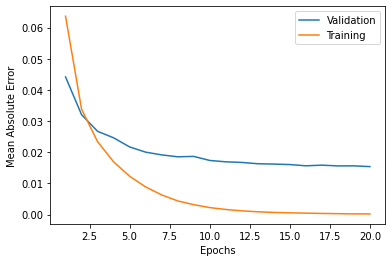

In [68]:
# Compute the average of the per-epoch MAE scores for all folds
# Building the history of successive mean K-fold validation scores

average_val_mae_history = [
    np.mean([x[i] for x in all_val_mae_histories]) for i in range(num_epochs)]

average_train_mae_history = [
    np.mean([x[i] for x in all_train_mae_histories]) for i in range(num_epochs)]

plt.plot(range(1, len(average_val_mae_history) + 1), average_val_mae_history, label='Validation')
plt.plot(range(1, len(average_train_mae_history) + 1), average_train_mae_history, label = 'Training')
plt.xlabel('Epochs')
plt.ylabel('Mean Absolute Error')
plt.legend()
plt.savefig('Q1_DNN.png', dpi = 400)

In [67]:
def smooth_curve(points, factor=0.5):
    
    smoothed_points = []
    for point in points:
        if smoothed_points:
            previous = smoothed_points[-1]
            smoothed_points.append(previous * factor + point * (1 -factor))
        else:
            smoothed_points.append(point)
            
    return smoothed_points

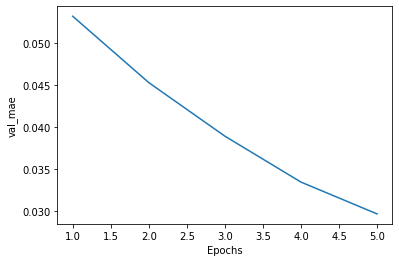

In [33]:
smooth_mae_history = smooth_curve(average_mae_history)
plt.plot(range(1, len(smooth_mae_history) + 1), smooth_mae_history)
plt.xlabel('Epochs')
plt.ylabel('val_mae')
plt.show()

In [34]:
# serialize model to JSON
model_json = model.to_json()
with open("Q1_Trained_Models/DNN_Model.json", "w") as json_file:
    json_file.write(model_json)
# serialize weights to HDF5
model.save_weights("Q1_Trained_Models/DNN_Model.h5")
print("Saved model to disk")

Saved model to disk


In [35]:
# Verify above by visually inspecting images from the predicted set
num_val_images = 10000

Predicted: 1
True: 1


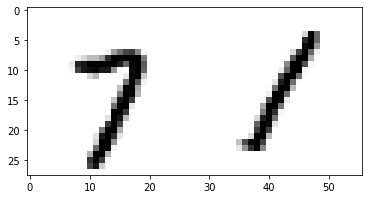

In [36]:
# Run this cell repeatedly to see multiple examples
check_index = random.randint(0,num_val_images)
plt.imshow(val_images[check_index].reshape(28,56), cmap = plt.cm.binary)
print("Predicted: " + str(np.argmax(y_predict[check_index])))
print("True: " + str(np.argmax(val_labels[check_index])))